In [12]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import time
from IPython.display import HTML, display
! pip install tabulate
import tabulate
import numpy as np
import gc
from tensorflow.keras.models import model_from_json
!pip install tqdm
!pip install h5py
import zipfile
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing
from tensorflow.keras.models import model_from_json

In [13]:
def scale(x):

    return (x - np.mean(x)) / np.std(x)

In [14]:
def preprocess(x):
    
    return x[:,:,:int(0.75*x.shape[2])]

In [15]:
os.chdir("/home/pk2573")
path = "/home/pk2573/Capstone_Data"

In [16]:
json_file = open('model_heat1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_heat_1 = model_from_json(loaded_model_json)
model_heat_1.load_weights("model_heat1.h5")
model_heat_1.compile(loss = 'mse', optimizer = tf.train.AdamOptimizer())

In [17]:
json_file = open('model_heat2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_heat_2 = model_from_json(loaded_model_json)
model_heat_2.load_weights("model_heat2.h5")
model_heat_2.compile(loss = 'mse', optimizer = tf.train.AdamOptimizer())

In [18]:
json_file = open('model_heat3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_heat_3 = model_from_json(loaded_model_json)
model_heat_3.load_weights("model_heat3.h5")
model_heat_3.compile(loss = 'mse', optimizer = tf.train.AdamOptimizer())

In [19]:
subdirs = [subdir for subdir, dirs, files in os.walk(path)]
subdirs.remove(path + "/Re554Fr5_coarse8/.ipynb_checkpoints")
subdirs.remove(path + "/Re309Fr2_coarse8/.ipynb_checkpoints")
subdirs.remove(path + "/Re546_coarse8/.ipynb_checkpoints")
subdirs.remove(path + "/.ipynb_checkpoints")
subdirs.remove(path + "/Re1243Fr20_coarse4")
subdirs = subdirs[1:]
subdirs

['/home/pk2573/Capstone_Data/Re1243Fr20_coarse16',
 '/home/pk2573/Capstone_Data/Re309Fr2_coarse8',
 '/home/pk2573/Capstone_Data/Re1243Fr20_coarse8',
 '/home/pk2573/Capstone_Data/Re554Fr5_coarse8',
 '/home/pk2573/Capstone_Data/Re1243Fr20_coarse24',
 '/home/pk2573/Capstone_Data/Re546_coarse8']

Running Re1243Fr20_coarse16
Running Re309Fr2_coarse8
Running Re1243Fr20_coarse8
Running Re554Fr5_coarse8
Running Re1243Fr20_coarse24
Running Re546_coarse8


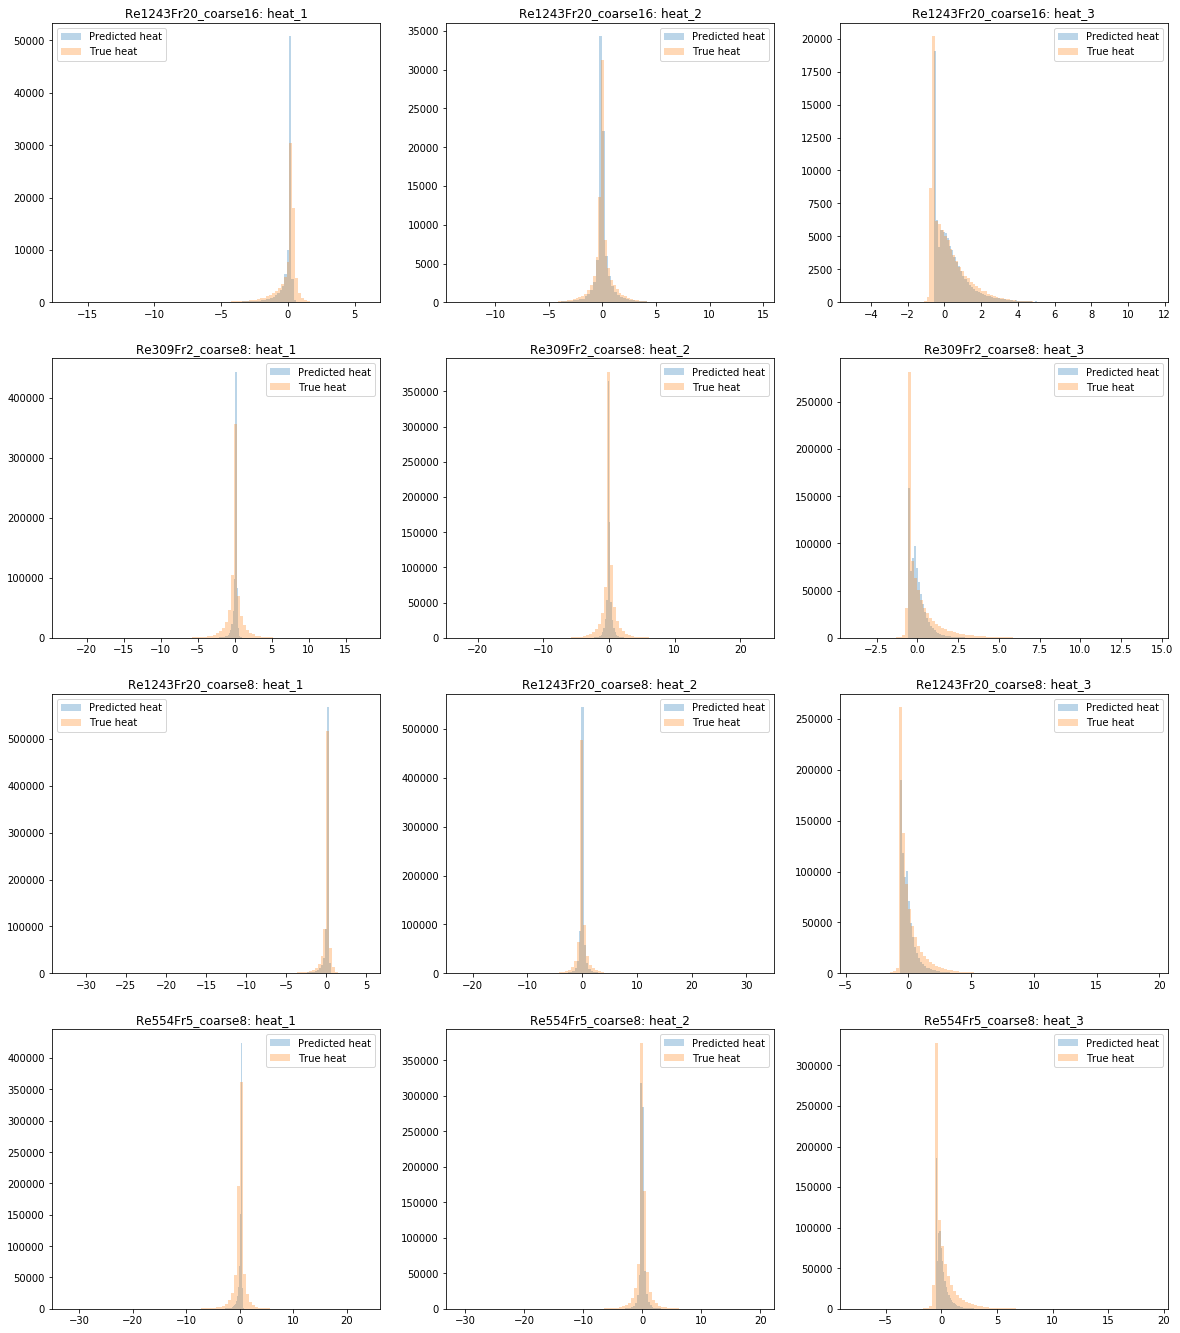

In [20]:
out = [["Data Source", "Heat_1", "Heat_2", "Heat_3"]]
fig = plt.figure(figsize = (20, 36))
count = 1

for path in subdirs:
    print("Running " + path.split("/")[-1])
    os.chdir(path)
    
    try:
        u = loadmat('u_F_xyz_T1.mat')
        u = preprocess(scale(u[list(u.keys())[-1]]))
        v = loadmat('v_F_xyz_T1.mat')
        v = preprocess(scale(v[list(v.keys())[-1]]))
        w = loadmat('w_F_xyz_T1.mat')
        w = preprocess(scale(w[list(w.keys())[-1]]))
        heat_1 = loadmat('Heat1_xyz_T1.mat')
        heat_1 = preprocess(scale(heat_1[list(heat_1.keys())[-1]]))
        heat_2 = loadmat('Heat2_xyz_T1.mat')
        heat_2 = preprocess(scale(heat_2[list(heat_2.keys())[-1]]))
        heat_3 = loadmat('Heat3_xyz_T1.mat')
        heat_3 = preprocess(scale(heat_3[list(heat_3.keys())[-1]]))

        x = np.array([u, v, w])
        x = np.transpose(x, [1, 2, 3, 0])
        x = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)

        del u
        del v
        del w
        gc.collect()

        sample = []
        size = 3
        y_heat_1 = []
        y_heat_2 = []
        y_heat_3 = []
        for i in range(size, x.shape[0] - size):
            for j in range(size, x.shape[1] - size):
                for k in range(size, x.shape[2] - size):
                    sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
                    y_heat_1.append(heat_1[i - size][j - size][k - size])
                    y_heat_2.append(heat_2[i - size][j - size][k - size])
                    y_heat_3.append(heat_3[i - size][j - size][k - size])

        x = np.array(sample)

        y_heat_1 = np.array(y_heat_1)
        y_heat_2 = np.array(y_heat_2)
        y_heat_3 = np.array(y_heat_3)

        del sample
        gc.collect()

        output = [(y_heat_1, "heat_1", model_heat_1), (y_heat_2, "heat_2", model_heat_2), (y_heat_3, "heat_3", model_heat_3)]

        corrs = []
        for (y_true, name, model) in output:
            y_pred = model.predict(x).flatten()
            corrs.append(np.corrcoef(y_pred, y_true)[0, 1])

            if count <= 18:
                fig.add_subplot(6, 3, count)
                n_bins = 100
                plt.hist(y_pred, bins = n_bins, alpha = 0.3, label = "Predicted heat")
                plt.hist(y_true, bins = n_bins, alpha = 0.3, label = "True heat")
                plt.title(path.split("/")[-1] + ": " + name)
                plt.legend()
                plt.show

                count += 1

        out.append([path.split("/")[-1], str(np.round(corrs[0], 4)), str(np.round(corrs[1], 4)), str(np.round(corrs[2], 4))])

        del x
        del y_heat_1
        del y_heat_2
        del y_heat_3
        del model
        del y_pred
        del y_true
        gc.collect()
        
    except:
        pass

In [21]:
display(HTML(tabulate.tabulate(out, tablefmt = 'html')))

Data Source,Heat_1,Heat_2,Heat_3
Re1243Fr20_coarse16,0.7433,0.5964,0.7964
Re309Fr2_coarse8,0.2891,0.4797,0.6329
Re1243Fr20_coarse8,0.9078,0.7915,0.8765
Re554Fr5_coarse8,0.357,0.5032,0.6547
